# Feature Engineer Testing

In [1]:
#statistical
import pandas as pd
import numpy as np

#dataset
from sklearn.datasets import *

#mchine learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler

#graphing and display
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
%matplotlib inline

#feature engineer
import feature_engineer as fe

#other
from pprint import pprint

#warnings
import warnings
#warnings.filterwarnings('ignore', category = UndefinedMetricWarning)

In [2]:
def create_dataset(bunch):
    df = pd.DataFrame(bunch.data, columns = bunch.feature_names)
    df['target'] = bunch.target
    return df

def enrich_data(eng, X_train, X_test, y_train):
    eng.fit(X_train, y_train)
    X_train = eng.transform(X_train)
    X_test = eng.transform(X_test)
    return X_train, X_test

In [3]:
iris = load_iris()
boston_housing = load_boston()
diabetes = load_diabetes()
linnerud = load_linnerud()
wine = load_wine()
breast_cancer = load_breast_cancer()

# Create Dataset Map

In [4]:
datasets = {}
for name, bunch in zip(['iris', 'wine', 'breast_cancer'],
                       [iris, wine, breast_cancer]):
    datasets[name] = create_dataset(bunch)

### Show a Single Dataset

In [5]:
datasets['iris'].head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


# Define The Test Metrics

In [6]:
metrics = {'accuracy' : {'metric' : accuracy_score, 'kwargs' : {'normalize' : True}},
           'precision' : {'metric' : precision_score, 'kwargs' : {'average' : 'weighted'}},
           'recall' : {'metric' : recall_score, 'kwargs' : {'average' : 'weighted'}},
           'f1_score' : {'metric' : f1_score, 'kwargs' : {'average' : 'weighted'}}}

# Define The Models

In [7]:
models = {'logistic' : LogisticRegression(),
          'bayes' : GaussianNB(),
          'tree' : DecisionTreeClassifier(max_depth = 5)}

# Define The Hyperparameters

In [8]:
hyperparameters = {'random_seed' : 42,
                   'test_size' : 0.3,
                   'n_best' : 5}

# Define The Splitter

In [9]:
splitter = {'splitter' : train_test_split,
            'kwargs' : {'test_size' : hyperparameters['test_size'],
                        'random_state' : hyperparameters['random_seed']}}

# Demonstrate Data Enrichment

In [10]:
#define the feature engineer object
eng = fe.FeatureEngineer(model = models['logistic'],
                         scorer = metrics['f1_score']['metric'],
                         splitter = splitter['splitter'],
                         n_best = hyperparameters['n_best'],
                         scorer_kwargs = metrics['f1_score']['kwargs'],
                         splitter_kwargs = splitter['kwargs'])

#fit to a dataframe
sample = datasets['iris'].drop('target', axis = 1)
eng.fit(sample, datasets['iris'].target)
sample = eng.transform(sample)

C:\Users\rossr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Before

In [11]:
datasets['iris'].head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## After

In [12]:
sample.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),petal length (cm)_sub_sepal length (cm),sepal length (cm)_truediv_petal length (cm),petal width (cm)_sub_sepal width (cm),petal length (cm)_sub_sepal width (cm),petal width (cm)_mul_petal length (cm)
0,5.1,3.5,1.4,0.2,-3.7,3.642857,-3.3,-2.1,0.28
1,4.9,3.0,1.4,0.2,-3.5,3.500000,-2.8,-1.6,0.28
2,4.7,3.2,1.3,0.2,-3.4,3.615385,-3.0,-1.9,0.26
3,4.6,3.1,1.5,0.2,-3.1,3.066667,-2.9,-1.6,0.30
4,5.0,3.6,1.4,0.2,-3.6,3.571429,-3.4,-2.2,0.28


# Produce Metrics Before and After Enrichment

In [13]:
results = pd.DataFrame(columns = ['dataset', 'enriched', 'metric', 'model', 'score'])
model_columns = pd.DataFrame(columns = ['dataset', 'enriched', 'metric', 'model', 'column', 'score'])
engine_columns = pd.DataFrame(columns = ['dataset', 'metric', 'model', 'column', 'score'])

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for enriched in [True, False]:
        for dataset_name, dataset in datasets.items():
            for metric_name, metric in metrics.items():
                for model_name, model in models.items():
                    
                    #create engine
                    eng = fe.FeatureEngineer(model = model,
                             scorer = metric['metric'],
                             splitter = splitter['splitter'],
                             n_best = hyperparameters['n_best'],
                             scorer_kwargs = metric['kwargs'],
                             splitter_kwargs = splitter['kwargs'])
                    
                    #split the dataset
                    X_train, X_test, y_train, y_test = splitter['splitter'](dataset.drop('target', axis = 1),
                                                                            dataset.target,
                                                                            **splitter['kwargs'])
                    
                    #enrich data
                    if enriched:
                        X_train, X_test = enrich_data(eng, X_train, X_test, y_train)
                    
                    #scale data
                    scaler = MinMaxScaler()
                    for df in X_train, X_test:
                        df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
                    
                    #fit model
                    model.fit(X_train, y_train)
                    
                    #obtain prediction
                    y_pred = model.predict(X_test)
                    
                    #obtain score
                    score = metric['metric'](y_test, y_pred, **metric['kwargs'])
                    
                    #append results
                    to_append = pd.DataFrame([[dataset_name, enriched, metric_name,
                                                   model_name, score]],
                                                 columns = results.columns)
                    
                    results = results.append(to_append, ignore_index = True)
                    
                    #append model coefficients
                    if model_name == 'logistic':
                        tuples = zip(model.coef_[0, :], X_train.columns)
                    elif model_name == 'tree':
                        tuples = zip(model.feature_importances_, X_train.columns)
                    
                    for coef, feature in tuples:
                        to_append = pd.DataFrame([[dataset_name, enriched,
                                                   metric_name, model_name,
                                                   feature, abs(coef)]],
                                                 columns = model_columns.columns)
                            
                        model_columns = model_columns.append(to_append, ignore_index = True)
                    
                    #append engine best columns
                    if enriched:
                        for score, feature in eng.best_columns.items():
                            to_append = pd.DataFrame([[dataset_name, metric_name,
                                                       model_name, feature.__name__,
                                                       score]],
                                                     columns = engine_columns.columns)
                            
                            engine_columns = engine_columns.append(to_append, ignore_index = True)
                    
                    clear_output()
                    print(dataset_name, model_name, metric_name, 'complete!')

breast_cancer tree f1_score complete!


# Results Before and After Enrichment

In [15]:
pd.pivot_table(data = results,
               index = ['dataset', 'model'],
               columns = ['metric', 'enriched'],
               values = 'score',
               aggfunc = 'mean')

metric                  accuracy            f1_score           precision  \
enriched                   False     True      False     True      False   
dataset       model                                                        
breast_cancer bayes     0.941520  0.947368  0.941317  0.953216  0.941391   
              logistic  0.964912  0.988304  0.964790  0.982484  0.964954   
              tree      0.953216  0.964912  0.953216  0.935776  0.947607   
iris          bayes     0.977778  1.000000  0.977745  1.000000  0.979365   
              logistic  0.977778  1.000000  0.977745  1.000000  0.979365   
              tree      1.000000  1.000000  1.000000  1.000000  1.000000   
wine          bayes     1.000000  1.000000  1.000000  1.000000  1.000000   
              logistic  1.000000  0.962963  1.000000  0.962963  1.000000   
              tree      0.962963  0.925926  0.944925  0.926229  0.963805   

metric                              recall            
enriched                   True      False     True   
dataset       model                                   
breast_cancer bayes     0.953216  0.941520  0.947368  
              logistic  0.982584  0.964912  0.988304  
              tree      0.964912  0.959064  0.976608  
iris          bayes     1.000000  0.977778  1.000000  
              logistic  1.000000  0.977778  1.000000  
              tree      0.979365  1.000000  1.000000  
wine          bayes     1.000000  1.000000  1.000000  
              logistic  0.966490  1.000000  0.962963  
              tree      0.929728  0.962963  0.944444

# Improvement After Enrichment Accross The Evaluation Metrics

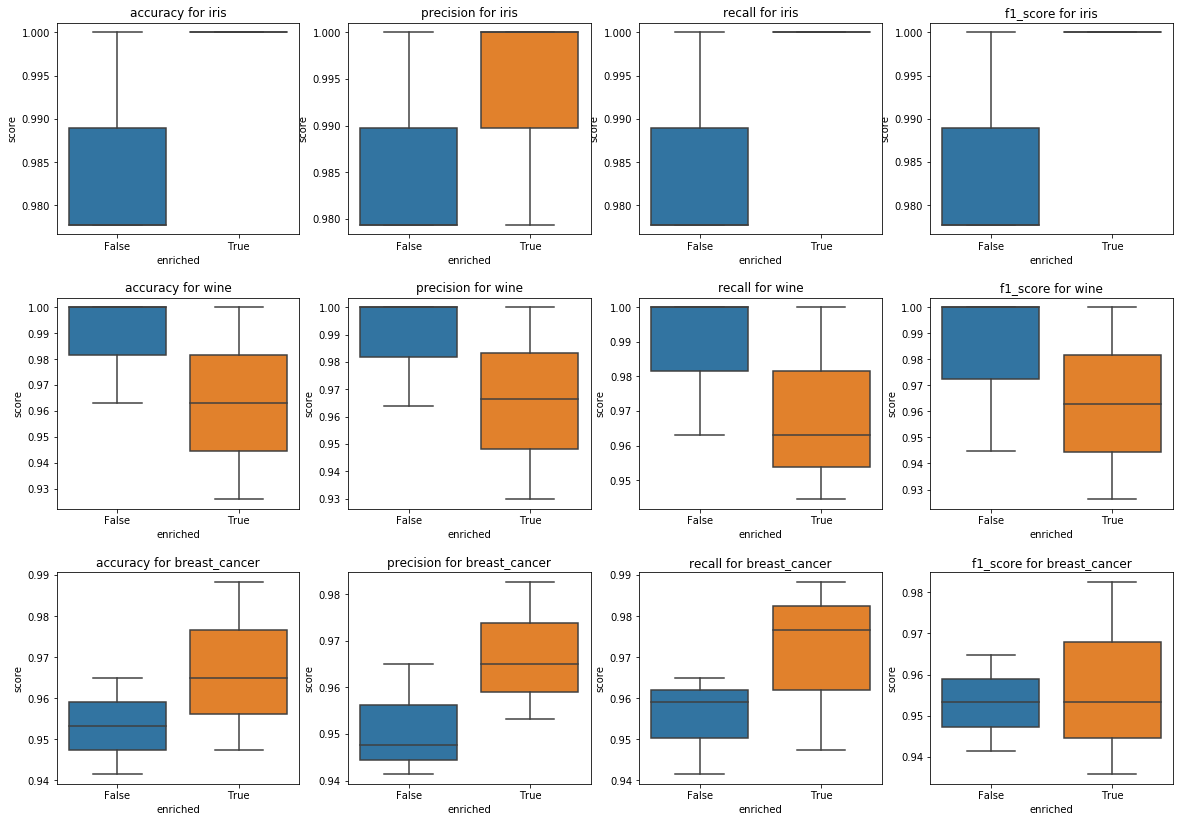

In [16]:
fig = plt.figure(figsize = (20, 14))
len_x = len(results.dataset.unique())
len_y = len(results.metric.unique())
i = 0
for dataset in results.dataset.unique():
    for metric in results.metric.unique():
        i += 1
        ax = plt.subplot(len_x, len_y, i)
        to_plot = results[(results.dataset == dataset) & (results.metric == metric)]
        ax.set_title('%s for %s' % (metric, dataset))
        sns.boxplot(x = 'enriched', y = 'score', data = to_plot)
plt.subplots_adjust(hspace = 0.3)

# Best Features Per Model
## Logistic Regression

In [17]:
n = 5
for dataset in model_columns.dataset.unique():
    print('Top %s columns for %s' % (n, dataset))
    display(model_columns[(model_columns.enriched == True) &
                          (model_columns.metric == 'f1_score') &
                          (model_columns.dataset == dataset) &
                          (model_columns.model == 'logistic')]\
            [['column', 'score']]\
            .sort_values(by = ['score'],
                         ascending = False)[:n])

Top 5 columns for iris


,column,score
60,petal width (cm)_mul_petal length (cm),0.723558
56,petal length (cm),0.545637
62,sepal width (cm)_truediv_petal width (cm),0.465449
54,sepal length (cm),0.421334
59,sepal length (cm)_truediv_petal width (cm),0.312646


Top 5 columns for wine


,column,score
195,flavanoids_mul_ash,0.949504
183,alcalinity_of_ash,0.763155
181,malic_acid,0.642028
182,ash,0.397309
189,color_intensity,0.354016


Top 5 columns for breast_cancer


,column,score
437,texture error,1.048449
459,worst perimeter_mul_mean concave points,0.635925
457,worst texture_mul_mean concave points,0.561500
428,mean perimeter,0.506012
447,worst texture,0.420846


## Decision Tree

In [18]:
for dataset in model_columns.dataset.unique():
    print('Top %s columns for %s' % (n, dataset))
    display(model_columns[(model_columns.enriched == True) &
                          (model_columns.metric == 'f1_score') &
                          (model_columns.dataset == dataset) &
                          (model_columns.model == 'tree')]\
            [['column', 'score']]\
            .sort_values(by = ['score'],
                         ascending = False)[:n])

Top 5 columns for iris


,column,score
67,petal width (cm)_mul_petal length (cm),0.505148
69,petal width (cm)_sub_sepal width (cm),0.469697
68,petal length (cm)_sub_sepal width (cm),0.025155
63,sepal length (cm),0.000000
64,sepal width (cm),0.000000


Top 5 columns for wine


,column,score
214,nonflavanoid_phenols_add_flavanoids,0.414659
207,color_intensity,0.411475
211,proline_mul_ash,0.136524
198,alcohol,0.021005
204,flavanoids,0.016337


Top 5 columns for breast_cancer


,column,score
494,worst texture_mul_mean concave points,0.804521
484,worst area,0.056991
483,worst perimeter,0.031678
472,texture error,0.027170
487,worst concavity,0.021051


## Best Features Heatmap

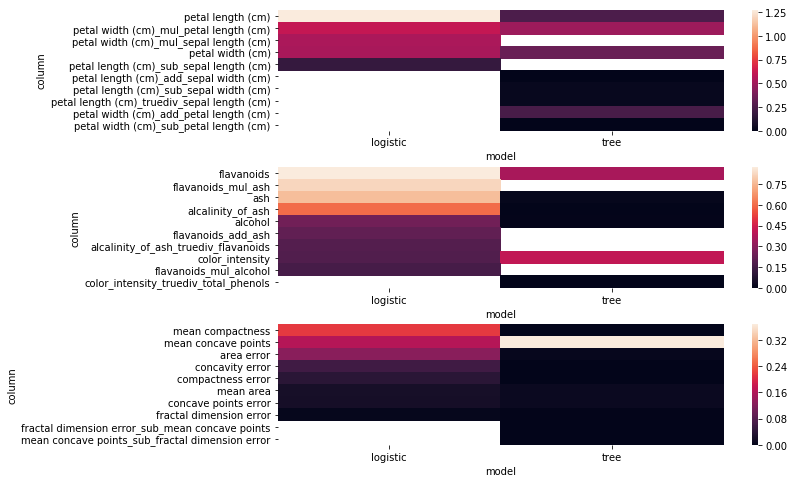

In [19]:
fig = plt.figure(figsize = (10, 8))
i = 0
len_x = len(model_columns.dataset.unique())
for dataset in model_columns.dataset.unique():
    to_plot = model_columns[model_columns.dataset == dataset]
    i += 1
    ax = plt.subplot(len_x, 1, i)
    sns.heatmap(pd.pivot_table(data = to_plot,
                           index = 'column',
                           columns = 'model',
                           values = 'score',
                           aggfunc = 'mean')[:n * 2]\
                .sort_values(by = 'logistic',
                             ascending = False))
plt.subplots_adjust(hspace = 0.3)

# Ranking Of Engineered Features

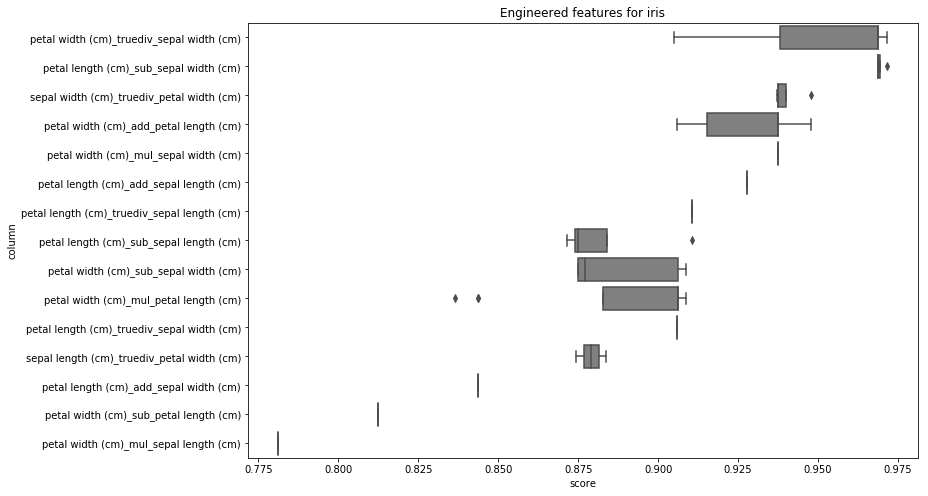

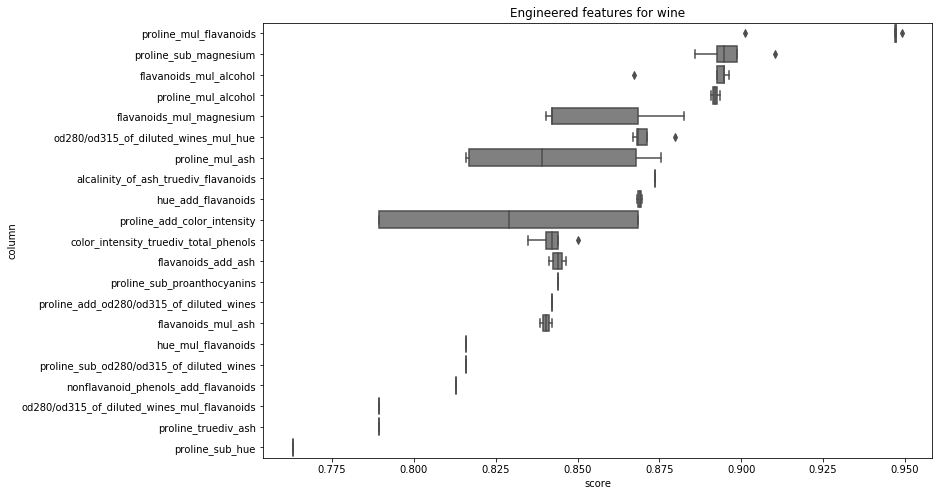

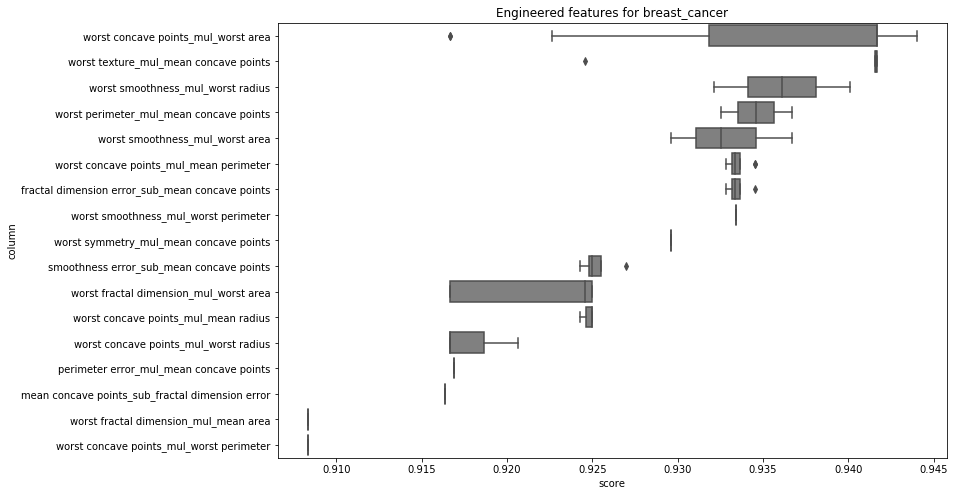

In [20]:
for dataset in engine_columns.dataset.unique():
    fig = plt.figure(figsize = (12, 8))
    to_plot = engine_columns[engine_columns.dataset == dataset]\
    .sort_values(by = ['score'], ascending = False)
    plt.title('Engineered features for %s' % dataset)
    sns.boxplot(y = 'column', x = 'score',
                #hue = 'model',
                data = to_plot, color = 'gray')